## Lecture 08 Multipling Sine Waves, Correlation and Auto-Correlation


   

In [2]:
# General useful imports
import numpy as np
import matplotlib.pyplot as plt
import librosa 
import librosa.display
from IPython.display import Audio

from scipy import signal


import numpy as np
from numpy import arange,linspace,mean, var, std, corrcoef, transpose, ones,log
from numpy.linalg import inv
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.mlab as mlab
from numpy.random import seed,random, randint, uniform
import math
from collections import Counter
import pandas as pd

#.  %matplotlib qt


# Basic audio parameters

SR            = 22050                  #  sample rate default for Librosa

# Utility functions

# Round to 4 decimal places

def round4(x):
    return np.around(x,4)    
    

In [3]:
# create a dictionary of piano key frequencies

# see https://en.wikipedia.org/wiki/Piano_key_frequencies

notenames = ['A0', 'Bb0', 'B0', 'C1', 'C#1', 'D1', 'Eb1', 'E1', 'F1', 'F#1',
       'G1', 'Ab1', 'A1', 'Bb1', 'B1', 'C2', 'C#2', 'D2', 'Eb2', 'E2',
       'F2', 'F#2', 'G2', 'Ab2', 'A2', 'Bb2', 'B2', 'C3', 'C#3', 'D3',
       'Eb3', 'E3', 'F3', 'F#3', 'G3', 'Ab3', 'A3', 'Bb3', 'B3', 'C4',
       'C#4', 'D4', 'Eb4', 'E4', 'F4', 'F#4', 'G4', 'Ab4', 'A4', 'Bb4',
       'B4', 'C5', 'C#5', 'D5', 'Eb5', 'E5', 'F5', 'F#5', 'G5', 'Ab5',
       'A5', 'Bb5', 'B5', 'C6', 'C#6', 'D6', 'Eb6', 'E6', 'F6', 'F#6',
       'G6', 'Ab6', 'A6', 'Bb6', 'B6', 'C7', 'C#7', 'D7', 'Eb7', 'E7',
       'F7', 'F#7', 'G7', 'Ab7', 'A7', 'Bb7', 'B7', 'C8', 'R']

# Create chromatic scale, e.g., as on the piano, as a dictionary    

Freqs = {} 

f = 27.5

for name in notenames:
    Freqs[name] = f
    f *= 2**(1/12)

Freqs['R'] = 0                    # a rest (silence) 

# test

Freqs['C4']

261.62556530059896

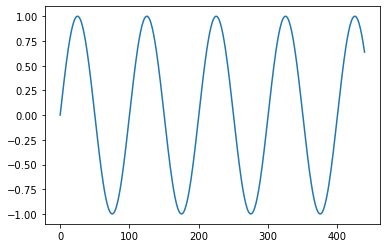

In [4]:
# to generate a signal W samples long with frequency f:

SR = 22050
W = 441             # W/SR = 0.2 seconds long with sample rate SR = 22050
T = np.arange(W)    # sample numbers
f = 220

# list comprehension (ok)

X = np.array( [ np.sin(2*np.pi*f*t/SR) for t in T] ) 

# applying scalar functions to an array (better)
      
X = np.sin(2*np.pi*f*T/SR) 
plt.plot(X)
plt.show()

## Librosa 

Please consult the useful tutorial here for additional information about using `librosa` and `IPython.display.Audio`:

https://musicinformationretrieval.com/ipython_audio.html

Complete librosa docs are here:

https://librosa.org/doc/latest/index.html 

### Reading audio files

In [5]:
# examples of useful librosa functions, see librosa docs for details and complete list

# get signal array and sample rate from example audio file included with librosa

x, sr = librosa.load(librosa.ex('trumpet'))

print(x.shape,sr,'\n')

# available example files
librosa.util.list_examples()  

(117601,) 22050 

AVAILABLE EXAMPLES
--------------------------------------------------------------------
brahms    	Brahms - Hungarian Dance #5
choice    	Admiral Bob - Choice (drum+bass)
fishin    	Karissa Hobbs - Let's Go Fishin'
nutcracker	Tchaikovsky - Dance of the Sugar Plum Fairy
trumpet   	Mihai Sorohan - Trumpet loop
vibeace   	Kevin MacLeod - Vibe Ace


In [6]:
# get signal array and sample rate from a local audio file, default sample rate is 22050 

x, sr = librosa.load('SteelString.wav')
print(len(x),sr)

# get signal array from a URL (this method is presented in the "Utilities" section of the librosa docs)
# if you use this method, note that the file's sample rate may be used, so may need to resample as shown

import soundfile
import io

from six.moves.urllib.request import urlopen

url = "https://www.cs.bu.edu/fac/snyder/cs583/AudioSamples/trumpet_A4_1_forte_normal.wav"

y, sr1 = soundfile.read(io.BytesIO(urlopen(url).read()))

print(len(y),sr1)

y = librosa.resample(y,sr1,SR)                                        # SR = 22050 in first code cell

print("Halving the sample rate makes the array half as long:", len(y))

44100 22050
54144 44100
Halving the sample rate makes the array half as long: 27072


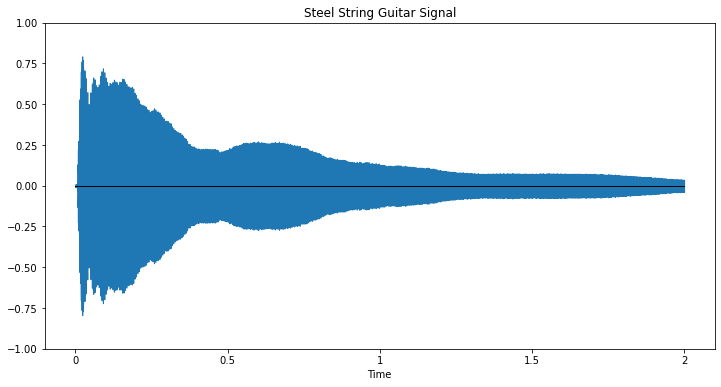

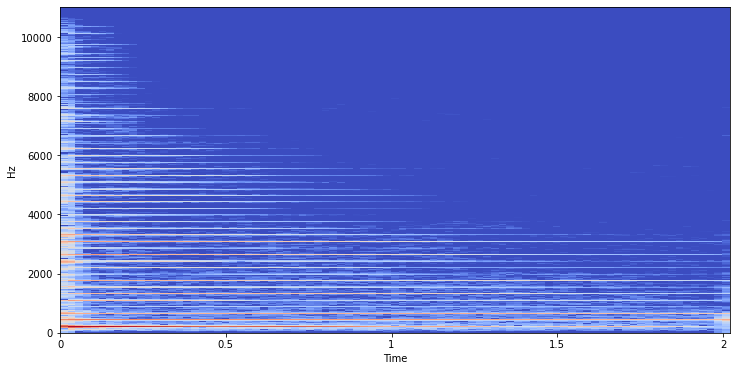

In [7]:
# display the waveform

def displaySignal(x,sr=SR,title='Signal X',):
    plt.figure(figsize=(12,6))
    plt.title(title)
    plt.ylim([-1.0,1.0])           # if you want the full range -1 .. 1, else will adapt to signal
    plt.plot([0,librosa.get_duration(x)],[0,0],linewidth=1,color='k') # if you want a 0 line
    #plt.grid()                    # if you want gridlines
    librosa.display.waveshow(x,sr=sr)
    plt.show()

# display the spectrogram

def displaySpectrogram(x,sr=SR,title='Signal X'):
    S = librosa.stft(x)
    Sdb = librosa.amplitude_to_db(abs(S))
    plt.figure(figsize=(12,6))
    librosa.display.specshow(Sdb, sr=sr, x_axis='time', y_axis='hz')
    #plt.colorbar()
    plt.show()

    
displaySignal(x,sr,"Steel String Guitar Signal") 

displaySpectrogram(x,sr,"Spectrogram for Steel String Guitar Signal")

Here is another way to show a spectrogram, using `matplotlib` built-in `specgram`:

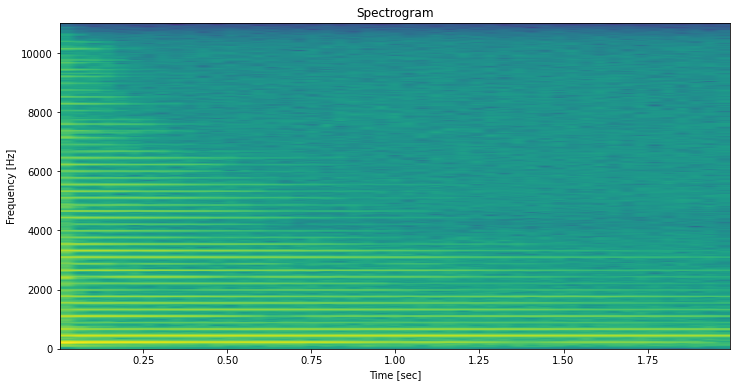

In [8]:
plt.figure(figsize=(12,6))
plt.title('Spectrogram')
plt.specgram(x, NFFT=1024,Fs=SR)
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.show()

###  Displaying Instantaneous Spectra

Matplotlib has a useful function to display a spectrum for the whole signal; by giving it
a short "window" you can get the same information contained in one column of the spectrogram:

https://matplotlib.org/3.1.1/api/_as_gen/matplotlib.pyplot.magnitude_spectrum.html

The term "magnitude spectrum" refers to the fact that we are interested in magnitude
of the various frequencies which make up the signal, instead of the power spectrum (square of the magnitudes) or the phase spectrum (what the phase of the various frequency components are). 


In [1]:
# Example: Create a signal with a simple spectrum

SR = 22050
f = 220
T = np.arange(SR*1)
X = 0.5 * np.sin( 2 * np.pi * 1000 * T / SR )
X += 0.3 * np.sin( 2 * np.pi * 3000 * T / SR )
X += 0.2 * np.sin( 2 * np.pi * 5000 * T / SR )

plt.figure(figsize=(12,6))
plt.title("Spectrum")
plt.magnitude_spectrum(X,SR)
plt.show()

plt.figure(figsize=(12,6))
plt.title("Spectrum")
plt.magnitude_spectrum(X,SR,scale='dB')
plt.show()

NameError: name 'np' is not defined

9999.999999999998
5000.000000000004
2500.000000000008
22050 11026


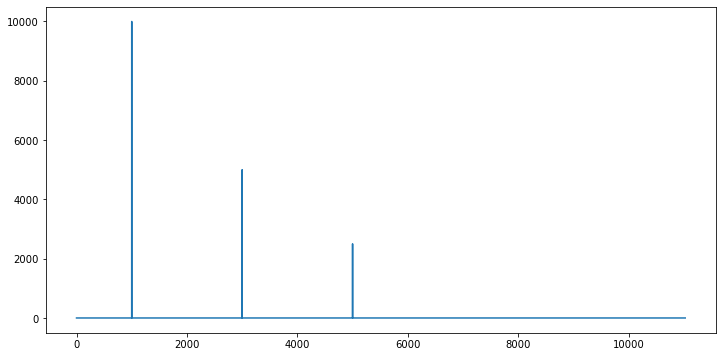

In [10]:
# You can also get the spectrum from the function using the Fast Fourier Transform, which
# we will study in some detail in the second part of the course. For now, we will use it to extract
# a spectrum from a signal.  This is just a wrapper around numpy fft to produce a real spectrum

# If the signal array is X, with len(X) number of samples, of duration D = len(X)/SR seconds, 
# the list returned is the amplitude of sine waves of frequency 0, 1/D, 2/D, 3/D, ..., SR/2 (the Nyquist limit)
# and the length of the list is len(X)/2 + 1. So each "frequency bin" at index k has the amplitude of
# the frequency k/D. 



def realFFT(X):
    return 2*abs(np.fft.rfft(X))/len(X) 

T = np.arange(SR*1)    # duration = 1 sec
X = 10000 * np.sin( 2 * np.pi * 1000 * T / SR )
X += 5000 * np.sin( 2 * np.pi * 3000 * T / SR )
X += 2500 * np.sin( 2 * np.pi * 5000 * T / SR )

S = realFFT(X)

print(S[1000])
print(S[3000])
print(S[5000])

print(len(X),len(S))

plt.figure(figsize=(12,6))
plt.plot(S)
plt.show()

In [11]:
# We can also return a list of triples of form  [f, A, phi] for each frequency
# f detected by the transform, however, note that, due to floating-point error, 
# you will get extremely small values instead of 0.0 for most of the frequencies; 
# therefore allow the option of filtering out these values using np.isclose(...)

T = np.arange(SR*0.1)    # duration = 0.1 sec
SR = 22050
X = 10000 * np.sin( 2 * np.pi * 1000 * T / SR )
X += 5000 * np.sin( 2 * np.pi * 3000 * T / SR )
X += 2500 * np.sin( 2 * np.pi * 5000 * T / SR )
    
def spectrumFFT(X,filterZeros=True):
    R =  np.fft.rfft(X)
    if(filterZeros):
        return np.array([ ( k*SR/len(X), 2.0 * np.absolute(R[k])/len(X),np.angle(R[k])+(np.pi/2) ) 
                            for k in range(len(R)) 
                                if not np.isclose(2.0 * np.absolute(R[k])/len(X),0.0) ]) 
    else:
        return np.array([ ( k*SR/len(X), 2.0 * np.absolute(R[k])/len(X),np.angle(R[k])+(np.pi/2) ) 
                            for k in range(len(R)) ]) 

print(spectrumFFT(X))
print()
S = spectrumFFT(X,False)
print(S[:5])
print()
print(S[98:104])
print()
print(S[-5:])

[[ 1.00000000e+03  1.00000000e+04 -3.19744231e-14]
 [ 3.00000000e+03  5.00000000e+03 -5.15143483e-14]
 [ 5.00000000e+03  2.50000000e+03 -2.46469511e-14]]

[[0.00000000e+00 3.31630435e-12 1.57079633e+00]
 [1.00000000e+01 5.95760525e-12 1.31452910e+00]
 [2.00000000e+01 9.78087769e-12 2.25611063e+00]
 [3.00000000e+01 1.26905561e-11 1.44138215e+00]
 [4.00000000e+01 1.10012997e-11 2.34277916e+00]]

[[ 9.80000000e+02  4.55615135e-11  3.20650173e+00]
 [ 9.90000000e+02  1.01092546e-10  3.10340360e+00]
 [ 1.00000000e+03  1.00000000e+04 -3.19744231e-14]
 [ 1.01000000e+03  9.99392442e-11 -2.87008904e-02]
 [ 1.02000000e+03  5.57464039e-11 -2.43583293e-04]
 [ 1.03000000e+03  4.02883933e-11  7.83284481e-02]]

[[ 1.09800000e+04  3.31397367e-11 -6.16546313e-01]
 [ 1.09900000e+04  4.28488203e-11  1.65438998e-01]
 [ 1.10000000e+04  3.18461470e-11  8.01926146e-01]
 [ 1.10100000e+04  2.70365187e-11  1.11503674e+00]
 [ 1.10200000e+04  3.40314115e-11  1.43812277e+00]]


## Lecture 8 material


In [12]:
def displaySignal(X,title='Signal X'):
    plt.figure(figsize=(15,3))
    plt.title(title)
    plt.ylim([-1.1,1.1])
    plt.plot([0,len(X)],[0,0],'k')
    plt.plot(X)
    plt.show()

$$ 2 \cdot mean(X \cdot Y) \ = \ 2 \cdot {\sum_{k=0}^{N} X[k]\cdot Y[k]\over N}\ =\  {2\over N}\cdot X @ Y$$

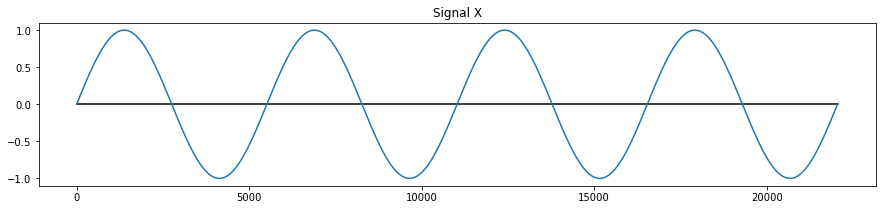

sum(X) = -1.1361202777171453e-12


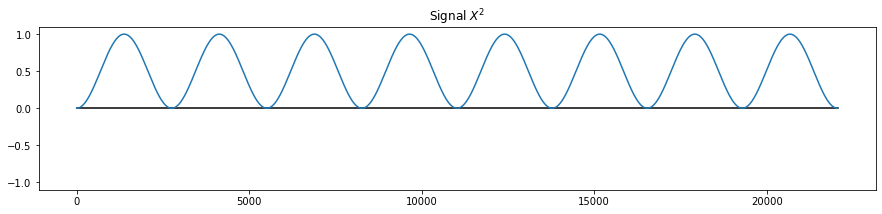

sum(X^2) = 11025.0


In [13]:
# make a one second signal of frequency f
f = 4
X = np.sin(2*np.pi*f*np.arange(SR)/SR) 

X2 = X**2

displaySignal(X,"Signal X")

print('sum(X) =', sum(X))
              
displaySignal(X**2,"Signal $X^2$")              
print('sum(X^2) =', round4(sum(X**2)))

Compare with the trig formula:

$$sin^2(x) = {1 - cos(2x)\over 2}$$


### Dot product

To sum up the result of a multiplication of two sine waves is really just the dot product:

$$A @ B\ =\  \sum_k A[k]\cdot B[k]$$

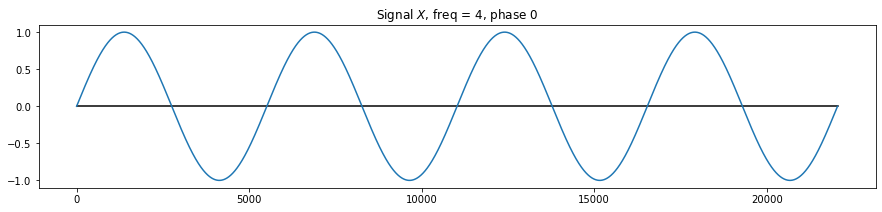

mean(X) = 0.0


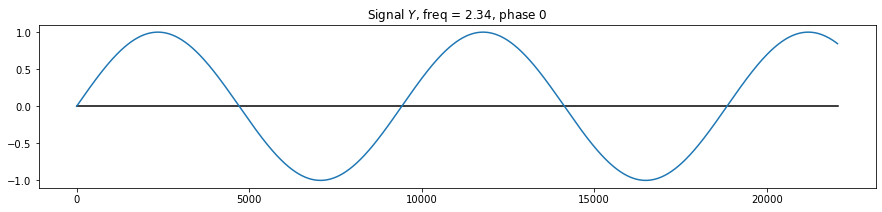

mean(Y) = 0.1044


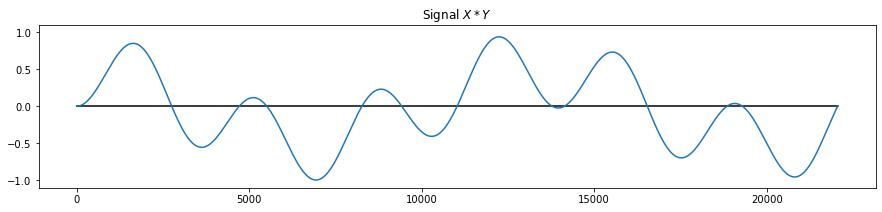

mean(X*Y) = -0.0511


In [14]:
# display two different waves and their product, and report the dot product
fx = 4
px = 0
X = np.sin(2*np.pi*fx*np.arange(SR)/SR + px) 
fy = 2.34
py = 0 
Y = np.sin(2*np.pi*fy*np.arange(SR)/SR + py) 

displaySignal(X,'Signal $X$, freq = '+ str(fx)+', phase 0')
print('mean(X) =',round4(np.mean(X)))
displaySignal(Y,'Signal $Y$, freq = '+ str(fy)+', phase '+str(round4(py)))
print('mean(Y) =',round4(np.mean(Y)))
displaySignal(X*Y,'Signal $X*Y$')
print('mean(X*Y) =',round4(np.mean(X*Y)))

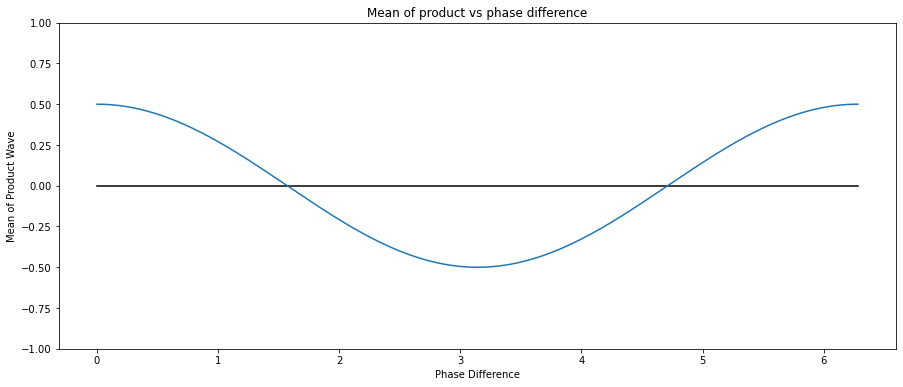

In [15]:
# dot product as we change the phase but keep the frequency the same

D = np.zeros(1000)
fx = 4
fy = 4
P = np.linspace(0,2*np.pi,1000)
for k in range(1000):
    X = np.sin(2*np.pi*fx*np.arange(SR)/SR) 
    Y = np.sin(2*np.pi*fy*np.arange(SR)/SR + P[k]) 
    D[k] = np.mean(X * Y)

plt.figure(figsize=(15,6))
plt.title('Mean of product vs phase difference')
plt.ylim([-1,1])
plt.plot([0,2*np.pi],[0,0],'k')
plt.plot(P,D)
plt.xlabel('Phase Difference')
plt.ylabel('Mean of Product Wave')
plt.show()

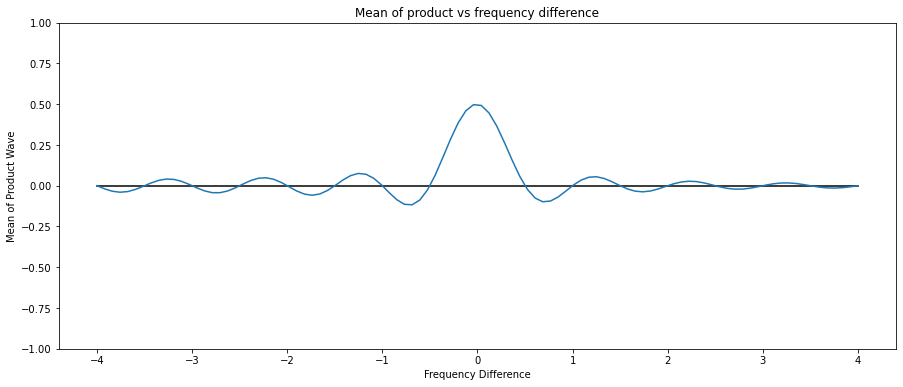

In [100]:
# dot product as we change the frequency but keep the phase the same

D = np.zeros(100)
fx = 4
fy = 4
fy = np.linspace(0,8,100)
for k in range(100):
    X = np.sin(2*np.pi*fx*np.arange(SR)/SR) 
    Y = np.sin(2*np.pi*fy[k]*np.arange(SR)/SR) 
    D[k] = np.mean(X * Y)

plt.figure(figsize=(15,6))
plt.title('Mean of product vs frequency difference')
plt.ylim([-1,1])
plt.plot([-4,4],[0,0],'k')
plt.plot(fy - fx,D)
plt.xlabel('Frequency Difference')
plt.ylabel('Mean of Product Wave')
plt.show()

$$sinc(x) = {sin(x)\over x}$$

In [82]:
import plotly.graph_objects as go

N = 301
k = int((N-1)/2)
lo = np.linspace(0,2*np.pi,k+1)
hi = np.linspace(2*np.pi,4*np.pi,k+1)
phi = np.concatenate([lo,hi[1:]])

SR = 100000
Z = np.zeros((N,N))
f = 4
freq = np.linspace(1,7,N)   # so every 0.02 Hz

X = np.sin(2*np.pi*fx*np.arange(SR)/SR) 

for r in range(N):
    for c in range(N):        
        Y = np.sin(2*np.pi*freq[c]*np.arange(SR)/SR + phi[r]) 
        Z[r][c] = np.mean(X * Y)
        


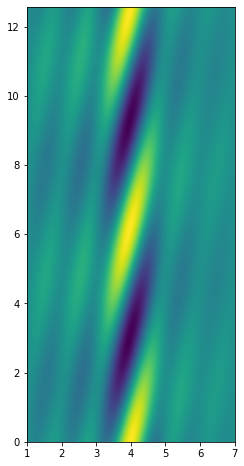

In [98]:
plt.figure(figsize=(10,8))
plt.imshow(Z,extent=[1,7,0,4*np.pi])
plt.show()

In [99]:
x, y = freq, phi
fig = go.Figure(data=[go.Surface(z=Z, x=x, y=y)])
fig.update_layout(title='Mean of Product', 
                  xaxis_title="Frequency Differential",
                  yaxis_title="Phase Differential",
                  autosize=False,
                  width=1000, height=1000,
                  margin=dict(l=65, r=50, b=65, t=90))


fig.show()

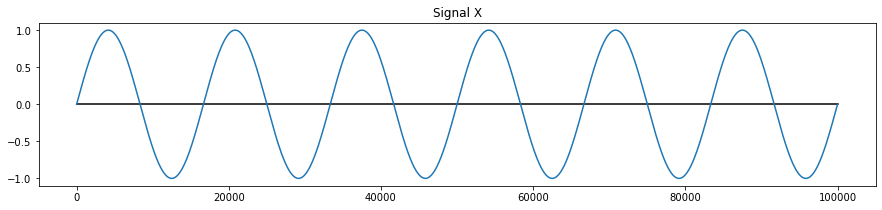

In [107]:
X = np.sin(2*np.pi*6*np.arange(SR)/SR) 


displaySignal(X,"Signal X")

$$   2\cdot {A\cdot X @ Y\over N} = A\left(2\cdot {X @ Y\over N}\right) = A $$

$$   2\cdot {X @ Y\over N} = 1.0$$